# Домашнее задание 1. Сравнение методов коллаборативной фильтрации по сходству пользователей и по сходству объектов


Полезная ссылка на довольно подробный обзор по теме: http://files.grouplens.org/papers/FnT%20CF%20Recsys%20Survey.pdf


1. Загрузите данные [Movie Lens](http://grouplens.org/datasets/movielens/), датасет на 1М рейтингов. Дополнительный бонус, если ваш код сможет обработать датасет на 10М. Я рекомендую сначала пробовать ваши методы на датасете из 100к рейтингов.  

2. Разбейте датасет на обучающую и тестовую выборку. 

Вариант 1: Тестовые пользователи -- это те, у кого ID делется на 5 без остатка.
Для каждого тестового пользователя скройте каждый десятый фильм по возрастанию ID.

Вариант 2: Тестовые пользователи -- это случайно выбранные 20% сохраните их список для воспроизводимости.
Для каждого тестового пользователя скройте каждый фильм с вероятностью 1/10, сохраните список скрытых фильмов.

Все пользователи и не скрытые фильмы это данные, на которых вы будете оценивать похожесть.

3. Выберите любые две меры похожести и реализуйте на их основе две модели рекомендаций на основе пользователей.
Для этих моделей посчитайте MAE и RMSE на всех скрытых оценках варианта 1. Какая модель оказалась лучше?

4. Повторите пункт 3 для варианта 2. Изменилось ли что-нибудь?

5. Для каждого тестового пользователя сгенерируйте рекомендации топ 10, 15, 20, 50, 100 фильмов у которых нет оценок. Посчитайте NDCG считая хорошими фильмы с оценкой 4 и выше.

6. Реализуте модель основанную на похожести предметов.

7. Повторите пункты 3-5 для этой модели. 

8. Насколько различны списки из top-n рекомендаций. Попробуйте улучшить результаты подбором $\beta$ для минимизации MAE (RMSE) в гибридных рекомендациях:
$$\beta\cdot r^{user-based}_{ui} + (1-\beta)\cdot r^{item-based}_{ui}, \mbox{ где } 0 \leq \beta \leq 1.$$ 

deadline 24.10.2021 23:59

In [367]:
from math import sqrt
from math import log2
from math import isnan

from random import random, seed

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import ndcg_score

# Load date

In [9]:
#Чтение данных
def loadMovieLens1M(path='./ml-1m'):
    # Получить названия фильмов
    movies={}
    for line in open(path+'/movies.dat'):
        (id,title)=line.split('::')[0:2] #при желании тут можно добавить чтение жанров.
        movies[id]=title
    # Загрузить данные
    prefs={}
    for line in open(path+'/ratings.dat'):
        (user,movieid,rating,ts)=line.split('::')
        prefs.setdefault(user,{})
        prefs[user][movies[movieid]]=float(rating)
    return prefs

In [10]:
critics = loadMovieLens1M()
pd.DataFrame.from_dict(critics).head()

,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
One Flew Over the Cuckoo's Nest (1975),5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,5.0,NaN,5.0,5.0,4.0,NaN,NaN,4.0
James and the Giant Peach (1996),3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
My Fair Lady (1964),3.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,4.0,NaN
Erin Brockovich (2000),4.0,NaN,NaN,NaN,3.0,5.0,NaN,NaN,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
"Bug's Life, A (1998)",5.0,NaN,5.0,NaN,5.0,NaN,NaN,NaN,4.0,4.0,...,NaN,NaN,NaN,NaN,5.0,4.0,NaN,NaN,NaN,NaN


## test train split

### Вариант 1:
Тестовые пользователи – это те, у кого ID делется на 5 без остатка. Для каждого тестового пользователя скройте каждый десятый фильм по возрастанию ID

In [11]:
all_users = [u for u in critics]
len(all_users)

6040

In [12]:
users_test_list = [u for u in critics if int(u) % 5 == 0]
len(users_test_list)

1208

In [13]:
critics_test = {}
# critics_train = {}
for u in users_test_list:
    critics_test[u] = {}
    # critics_train[u] = {}
    m_id = 0
    for m in critics[u]:
        m_id += 1
        if m_id % 10 == 0:
            critics_test[u][m] = critics[u][m]
        # else:
        #     critics_train[u][m] = critics[u][m]
pd.DataFrame.from_dict(critics_test).head()

,5,10,15,20,25,30,35,40,45,50,...,5995,6000,6005,6010,6015,6020,6025,6030,6035,6040
Donnie Brasco (1997),3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gladiator (2000),2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Seven (Se7en) (1995),3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Apollo 13 (1995),2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Usual Suspects, The (1995)",5.0,NaN,4.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
critics_train = {}
for u in all_users:
    if u not in users_test_list:
        critics_train[u] = {}
        for m in critics[u]:
            critics_train[u][m] = critics[u][m]
    else:
        critics_train[u] = {}
        m_id = 0
        for m in critics[u]:
            m_id += 1
            if m_id % 10 == 0:
                critics_train[u][m] = critics[u][m]

pd.DataFrame.from_dict(critics_train).head()

,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
One Flew Over the Cuckoo's Nest (1975),5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,5.0,NaN,NaN,5.0,4.0,NaN,NaN,NaN
James and the Giant Peach (1996),3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
My Fair Lady (1964),3.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,4.0,NaN
Erin Brockovich (2000),4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
"Bug's Life, A (1998)",5.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN


### Вариант 2:
Тестовые пользователи – это случайно выбранные 20% сохраните их список для воспроизводимости. Для каждого тестового пользователя скройте каждый фильм с вероятностью 1/10, сохраните список скрытых фильмов.

In [15]:
seed(2)
users_test_list_2 = [u for u in critics if random()<=0.2]
len(users_test_list_2)

1175

In [16]:
seed(2)
critics_test_2 = {}
critics_train_2_ = {}
for u in users_test_list_2:
    critics_test_2[u] = {}
    critics_train_2_[u] = {}
    for m in critics[u]:
        if random()<=0.2:
            critics_test_2[u][m] = critics[u][m]
        else:
            critics_train_2_[u][m] = critics[u][m]
pd.DataFrame.from_dict(critics_test_2).head()

,3,4,12,21,22,30,32,36,46,66,...,6000,6006,6008,6018,6021,6025,6028,6031,6032,6037
Mission: Impossible (1996),3.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Raising Arizona (1987),4.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
Being John Malkovich (1999),3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,4.0
American Beauty (1999),4.0,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Toy Story 2 (1999),3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
pd.DataFrame.from_dict(critics_train_2_).head()

,3,4,12,21,22,30,32,36,46,66,...,6000,6006,6008,6018,6021,6025,6028,6031,6032,6037
Animal House (1978),4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
"Full Monty, The (1997)",2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28 Days (2000),3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Happy Gilmore (1996),4.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
"Golden Child, The (1986)",4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
critics_train_2 = {}
for u in all_users:
    if u not in users_test_list_2:
        critics_train_2[u] = {}
        for m in critics[u]:
            critics_train_2[u][m] = critics[u][m]
    else:
        critics_train_2[u] = {}
        for m in critics[u]:
            if m not in [m for m in critics_train_2_[u]]:
                critics_train_2[u][m] = critics[u][m]
pd.DataFrame.from_dict(critics_train_2).head()

,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
One Flew Over the Cuckoo's Nest (1975),5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,5.0,5.0,NaN,NaN,NaN,4.0
James and the Giant Peach (1996),3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
My Fair Lady (1964),3.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,4.0,NaN
Erin Brockovich (2000),4.0,NaN,NaN,NaN,3.0,5.0,NaN,NaN,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
"Bug's Life, A (1998)",5.0,NaN,5.0,NaN,5.0,NaN,NaN,NaN,4.0,4.0,...,NaN,NaN,NaN,NaN,5.0,4.0,NaN,NaN,NaN,NaN


### Выберите любые две меры похожести и реализуйте на их основе две модели рекомендаций на основе пользователей.

In [47]:
# Возвращает сходство person1 и person2 на основе расстояния
def sim_kernel(prefs,person1,person2,alpha=0.3):
    # Получить список предметов, оцененных обоими
    si={}
    for item in prefs[person1]:
        if item in prefs[person2]:
            si[item]=1
    # Если нет ни одной общей оценки, вернуть 0
    if len(si)==0: return 0
    # Сложить квадраты разностей
    sum_of_squares=sum([pow(prefs[person1][item]-prefs[person2][item],2)
                        for item in prefs[person1] if item in prefs[person2]])
    return np.exp(-alpha*sum_of_squares)


# Возвращает коэффициент корреляции Пирсона между p1 и p2
def sim_pearson(prefs,p1,p2):
    # Получить список предметов, оцененных обоими
    si={}
    for item in prefs[p1]:
        if item in prefs[p2]: si[item]=1

    # Если нет ни одной общей оценки, вернуть 0
    if len(si)==0: return 0

    # Количество соместно оцененных фильм
    n=len(si)

    # Вычислить сумму всех предпочтений
    sum1=sum([prefs[p1][it] for it in si])
    sum2=sum([prefs[p2][it] for it in si])

    # Вычислить сумму квадратов
    sum1Sq=sum([pow(prefs[p1][it],2) for it in si])
    sum2Sq=sum([pow(prefs[p2][it],2) for it in si])

    # Вычислить сумму произведений
    pSum=sum([prefs[p1][it]*prefs[p2][it] for it in si])

    # Вычислить коэффициент Пирсона
    num=pSum-(sum1*sum2/n)
    den=sqrt((sum1Sq-pow(sum1,2)/n)*(sum2Sq-pow(sum2,2)/n))
    if den==0: return 0

    r=round(num/den, 2)

    return r

In [22]:
from itertools import islice

In [37]:
list(islice(critics_test.items(), 1))

[('5',
  {'Donnie Brasco (1997)': 3.0,
   'Gladiator (2000)': 2.0,
   'Seven (Se7en) (1995)': 3.0,
   'Apollo 13 (1995)': 2.0,
   'Usual Suspects, The (1995)': 5.0,
   'Thin Red Line, The (1998)': 5.0,
   'Ghostbusters (1984)': 3.0,
   'Topsy-Turvy (1999)': 5.0,
   'Go (1999)': 4.0,
   'Fargo (1996)': 4.0,
   'Fast, Cheap & Out of Control (1997)': 4.0,
   'Fight Club (1999)': 4.0,
   "Jacob's Ladder (1990)": 3.0,
   'Incredibly True Adventure of Two Girls in Love, The (1995)': 3.0,
   'Waiting for Guffman (1996)': 4.0,
   'In the Company of Men (1997)': 1.0,
   'Bullets Over Broadway (1994)': 4.0,
   'Much Ado About Nothing (1993)': 3.0,
   'Rosencrantz and Guildenstern Are Dead (1990)': 3.0})]

In [49]:
def topMatches(prefs,person,n=25,similarity=sim_pearson):
    sim_list = sorted([(similarity(prefs, person, p), p) for p in prefs if p != person],
                      reverse = True)
    return sim_list[:n]

topMatches(critics_train, list(critics_test.keys())[0])

[(1.0, '993'),
 (1.0, '97'),
 (1.0, '964'),
 (1.0, '893'),
 (1.0, '887'),
 (1.0, '88'),
 (1.0, '838'),
 (1.0, '811'),
 (1.0, '78'),
 (1.0, '773'),
 (1.0, '764'),
 (1.0, '753'),
 (1.0, '734'),
 (1.0, '723'),
 (1.0, '717'),
 (1.0, '710'),
 (1.0, '68'),
 (1.0, '657'),
 (1.0, '628'),
 (1.0, '613'),
 (1.0, '6022'),
 (1.0, '5992'),
 (1.0, '5988'),
 (1.0, '5981'),
 (1.0, '5919')]

In [348]:
# Получить рекомендации для заданного человека, пользуясь взвешенным средним
# оценок, данных всеми остальными пользователями
def getRecommendations(prefs, test,person,similarity=sim_pearson,
                       mode = "exact"):
    top_persons = topMatches(prefs,person, 100, similarity)
    film_sum = {}
    film_multiplyer = {}
    for p in top_persons:
        if p[0] <= 0:
            break
        if mode != "exact":
            for movie in prefs[p[1]]:
                if not movie in film_sum:
                    film_sum[movie] = 0
                    film_multiplyer[movie] = 0

                film_sum[movie] += prefs[p[1]][movie]*p[0]
                film_multiplyer[movie] += p[0]
        if mode == "exact":
            test_list = test[person]
            for movie in prefs[p[1]]:
                if movie in test_list:
                    if not movie in film_sum:
                        film_sum[movie] = 0
                        film_multiplyer[movie] = 0

                    film_sum[movie] += prefs[p[1]][movie]*p[0]
                    film_multiplyer[movie] += p[0]

    if mode == "only_NA":
        recomend = sorted([(movie, film_sum[movie]/film_multiplyer[movie]) for movie in film_sum if movie not in prefs[person]], reverse = True)
    elif mode == "all":
        recomend = sorted([(movie, film_sum[movie]/film_multiplyer[movie]) for movie in film_sum], reverse = True)
    elif mode == "exact":
        recomend = sorted([(movie, film_sum[movie]/film_multiplyer[movie]) for movie in film_sum if movie in test_list], reverse = True)

    return dict(recomend)

In [347]:
# Как же я доволен собой, господь
def getRecommendations_weighted(prefs, test, person,similarity=sim_pearson,
                               mode = "exact"):
    '''
    :param prefs: train df
    :param person: test df
    :param similarity: method for user user sim
    :param test_list: list of items to predict
    :return: dict with movies and ratings
    '''
    top_persons = topMatches(prefs,person, 100, similarity)
    test_list = test[person]
    film_sum = {}
    film_multiplyer = {}
    # user 1 average
    person_mean = np.mean(list(prefs[person].values()))
    for p in top_persons:
        # user_ratings = []
        user_ratings_2 = {}
        # берём только от похожих
        if p[0] <= 0.5:
            break
        for movie in prefs[p[1]]:
            ## считаем среднюю оценку и стандартное отклонение других пользователей
            # user_ratings.append(prefs[p[1]][movie])
            user_ratings_2[movie] = prefs[p[1]][movie]
            if mode == "exact":
                if movie in test_list:
                    if not movie in film_sum:
                        film_sum[movie] = 0
                        film_multiplyer[movie] = 0

                    ### типа з скор что-ли
                    film_sum[movie] += p[0] * (prefs[p[1]][movie] - np.array(list(user_ratings_2.values())).mean()) / (np.array(list(user_ratings_2.values())).std() + 0.000000000001)
                    film_multiplyer[movie] += p[0]
            if mode == "only_NA":
                if not movie in film_sum:
                    film_sum[movie] = 0
                    film_multiplyer[movie] = 0
                    ### типа з скор что-ли
                film_sum[movie] += p[0] * (prefs[p[1]][movie] - np.array(list(user_ratings_2.values())).mean()) / (np.array(list(user_ratings_2.values())).std() + 0.000000000001)
                film_multiplyer[movie] += p[0]
    ## добавляем среднюю оценку изначального пользователя
    if mode == "exact":
        recomend = sorted([(movie, person_mean + film_sum[movie]/film_multiplyer[movie]) for movie in film_sum], reverse = True)
    if mode == "only_NA":
        recomend = sorted([(movie, person_mean + film_sum[movie]/film_multiplyer[movie]) for movie not in prefs[person]]], reverse = True)

    return dict(recomend)

SyntaxError: invalid syntax (Temp/ipykernel_8864/1215301803.py, line 47)

In [321]:
%%time
rec1 = getRecommendations(critics_train, critics_test, list(critics_test.keys())[0],
                   mode = "exact",)
rec1

Wall time: 43.8 ms


{'Waiting for Guffman (1996)': 4.666666666666667,
 'Usual Suspects, The (1995)': 4.916666666666667,
 'Topsy-Turvy (1999)': 4.5,
 'Thin Red Line, The (1998)': 4.75,
 'Seven (Se7en) (1995)': 3.0,
 'Rosencrantz and Guildenstern Are Dead (1990)': 4.0,
 'Much Ado About Nothing (1993)': 4.0,
 "Jacob's Ladder (1990)": 3.4,
 'Incredibly True Adventure of Two Girls in Love, The (1995)': 3.5,
 'In the Company of Men (1997)': 2.0,
 'Go (1999)': 4.555555555555555,
 'Gladiator (2000)': 3.515151515151515,
 'Ghostbusters (1984)': 3.5357142857142856,
 'Fight Club (1999)': 4.739130434782608,
 'Fast, Cheap & Out of Control (1997)': 4.333333333333333,
 'Fargo (1996)': 4.4324324324324325,
 'Donnie Brasco (1997)': 3.6,
 'Bullets Over Broadway (1994)': 4.428571428571429,
 'Apollo 13 (1995)': 3.5833333333333335}

In [324]:
%%time
rec2 = getRecommendations_weighted(critics_train, critics_test,
                            person=list(critics_test.keys())[1])
rec2

Wall time: 62.5 ms


{'While You Were Sleeping (1995)': 4.60855995962684,
 'Twelve Monkeys (1995)': 4.8780035984657655,
 'Teenage Mutant Ninja Turtles (1990)': 2.7131571989514667,
 'Star Trek: The Wrath of Khan (1982)': 3.030221698714085,
 'Star Trek: Generations (1994)': 4.44897403710044,
 'Soylent Green (1973)': 3.6558047010178383,
 'So I Married an Axe Murderer (1993)': 3.5399004647394356,
 'Santa Claus: The Movie (1985)': 3.610109684254234,
 'Raising Arizona (1987)': 3.577824431252283,
 'Princess Bride, The (1987)': 5.07565336610537,
 'Planet of the Apes (1968)': 3.960343690065309,
 "Mr. Holland's Opus (1995)": 4.765987153500352,
 'Message in a Bottle (1999)': 3.5120003999572837,
 'Little Mermaid, The (1989)': 4.8284206774447975,
 'Last of the Mohicans, The (1992)': 3.962614067047637,
 'Jungle Book, The (1967)': 3.2192864210647736,
 'Jerk, The (1979)': 3.5895746124277053,
 'Jack (1996)': 4.430386077045802,
 'High Fidelity (2000)': 3.4860546666174086,
 'Hamlet (1990)': 4.01273532476396,
 'Graduate, The 

### Для этих моделей посчитайте MAE и RMSE на всех скрытых оценках варианта 1. Какая модель оказалась лучше?

In [291]:
def my_score(real, predicted, score = "MAE"):
    results = {}
    if score == "MAE":
        for movie in predicted:
            results[movie] = abs(real[movie] - predicted[movie])
        result_score = np.average(list(results.values()))
    elif score == "RMSE":
        for movie in predicted:
            results[movie] = (real[movie] - predicted[movie])**2
        result_score = sqrt(np.average(list(results.values())))

    return result_score

In [292]:
my_score(critics_test[list(critics_test.keys())[0]],
         getRecommendations_weighted(critics_train,critics_test,
                                     person=list(critics_test.keys())[0],
                                        mode = "exact")
         )

0.4397949232358228

In [293]:
my_score(critics_test[list(critics_test.keys())[0]],
         getRecommendations_weighted(critics_train,critics_test,
                                     person = list(critics_test.keys())[0],
                                     mode = "exact"),
         score = "RMSE")

0.5801772699751014

## MAE

In [327]:
def evaluate_model(train, test,
                   rec_func = getRecommendations_weighted,
                   score_func = my_score):

    errors_mae = {}
    errors_rmse = {}
    for u in test:
        user_predicted = rec_func(prefs=train, test=test,
                                            person = u,
                                            mode = "exact")
        errors_mae[u] = score_func(test[u], user_predicted, score="MAE")
        errors_rmse[u] = score_func(test[u], user_predicted, score="RMSE")
    return errors_mae, errors_rmse

In [335]:
%%time
errors_base_MAE,errors_base_RMSE =  evaluate_model(critics_train, critics_test,
                                                   rec_func = getRecommendations)

errors_clear_MAE = {k: errors_base_MAE[k] for k in errors_base_MAE if not isnan(errors_base_MAE[k])}
errors_clear_RMSE = {k: errors_base_RMSE[k] for k in errors_base_RMSE if not isnan(errors_base_RMSE[k])}

print("mean error for base-level model:")
print(np.mean(list(errors_clear_MAE.values())))
print("mean error for base-level model:")
print(np.mean(list(errors_clear_RMSE.values())))

C:\Users\wirze\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\wirze\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


mean error for base-level model:
0.5870481473043274
mean error for base-level model:
0.7098542979801116
Wall time: 40.5 s


In [336]:
%%time
errors_weighted_MAE,errors_weighted_RMSE = evaluate_model(critics_train, critics_test,
                                                   rec_func = getRecommendations_weighted)

errors_clear_MAE = {k: errors_weighted_MAE[k] for k in errors_weighted_MAE \
                    if not isnan(errors_weighted_MAE[k])}
errors_clear_RMSE = {k: errors_weighted_RMSE[k] for k in errors_weighted_RMSE \
                     if not isnan(errors_weighted_RMSE[k])}

print("mean error for z-score model:")
print(np.mean(list(errors_clear_MAE.values())))
print("RMSE for z-score model:")
print(np.mean(list(errors_clear_RMSE.values())))

mean error for z-score model:
0.5056662452818075
RMSE for z-score model:
0.6170639663852051
Wall time: 50.2 s


In [337]:
df_errors_1 = pd.DataFrame(
    {'value': [*list(errors_base_MAE.values()),
                *list(errors_base_RMSE.values()),
                *list(errors_weighted_MAE.values()),
                *list(errors_weighted_RMSE.values())],
     'metric': [*np.repeat("MAE", len(errors_base_MAE.values()), axis=0),
               *np.repeat("RMSE", len(errors_base_RMSE.values()), axis=0),
               *np.repeat("MAE", len(errors_weighted_MAE.values()), axis=0),
               *np.repeat("RMSE", len(errors_weighted_RMSE.values()), axis=0)],
     'Model': [*np.repeat("base", len(errors_base_MAE.values()), axis=0),
               *np.repeat("base", len(errors_base_RMSE.values()), axis=0),
               *np.repeat("weighted", len(errors_weighted_MAE.values()), axis=0),
               *np.repeat("weighted", len(errors_weighted_RMSE.values()), axis=0)]}
)
df_errors_1.tail()

,value,metric,Model
4827,0.528545,RMSE,weighted
4828,0.983850,RMSE,weighted
4829,0.752316,RMSE,weighted
4830,1.270042,RMSE,weighted
4831,1.002084,RMSE,weighted


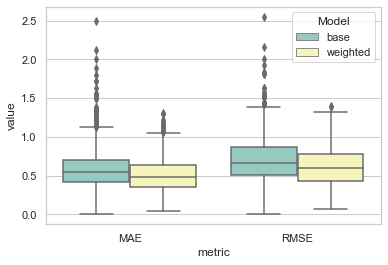

In [338]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="metric", y="value", hue="Model",
                 data=df_errors_1, palette="Set3")

If we are comparing two recommendation models by mean MAE and RMSE on all test users, it will be clear that weighted models is way better
## sampling 2

In [332]:
%%time
errors_base_MAE,errors_base_RMSE =  evaluate_model(critics_train_2, critics_test_2,
                                                   rec_func = getRecommendations)

errors_clear_MAE = {k: errors_base_MAE[k] for k in errors_base_MAE if not isnan(errors_base_MAE[k])}
errors_clear_RMSE = {k: errors_base_RMSE[k] for k in errors_base_RMSE if not isnan(errors_base_RMSE[k])}

print("mean error for base-level model:")
print(np.mean(list(errors_clear_MAE.values())))
print("mean error for base-level model:")
print(np.mean(list(errors_clear_RMSE.values())))

C:\Users\wirze\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\wirze\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


mean error for base-level model:
0.5816095572395393
mean error for base-level model:
0.7374463697701257
Wall time: 1min 2s


In [333]:
%%time
errors_weighted_MAE,errors_weighted_RMSE = evaluate_model(critics_train_2, critics_test_2,
                                                          rec_func = getRecommendations_weighted)

errors_clear_MAE = {k: errors_weighted_MAE[k] for k in errors_weighted_MAE
                    if not isnan(errors_weighted_MAE[k])}
errors_clear_RMSE = {k: errors_weighted_RMSE[k] for k in errors_weighted_RMSE
                     if not isnan(errors_weighted_RMSE[k])}

print("mean error for z-score model:")
print(np.mean(list(errors_clear_MAE.values())))
print("RMSE for z-score model:")
print(np.mean(list(errors_clear_RMSE.values())))

mean error for z-score model:
0.5461450529008043
RMSE for z-score model:
0.6864125569261842
Wall time: 1min 12s


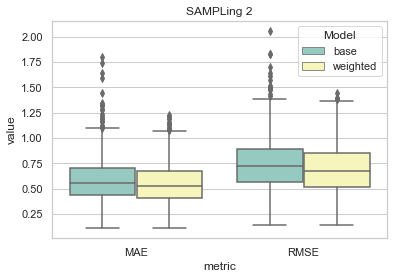

In [334]:
df_errors = pd.DataFrame(
    {'value': [*list(errors_base_MAE.values()),
                *list(errors_base_RMSE.values()),
                *list(errors_weighted_MAE.values()),
                *list(errors_weighted_RMSE.values())],
     'metric': [*np.repeat("MAE", len(errors_base_MAE.values()), axis=0),
               *np.repeat("RMSE", len(errors_base_RMSE.values()), axis=0),
               *np.repeat("MAE", len(errors_weighted_MAE.values()), axis=0),
               *np.repeat("RMSE", len(errors_weighted_RMSE.values()), axis=0)],
     'Model': [*np.repeat("base", len(errors_base_MAE.values()), axis=0),
               *np.repeat("base", len(errors_base_RMSE.values()), axis=0),
               *np.repeat("weighted", len(errors_weighted_MAE.values()), axis=0),
               *np.repeat("weighted", len(errors_weighted_RMSE.values()), axis=0)]}
)
ax = sns.boxplot(x="metric", y="value", hue="Model",
                 data=df_errors, palette="Set3")
ax.set_title('SAMPLing 2')
plt.show()

ok it looks like that error for sample 2 is large, but lets compare it

In [339]:
df_errors_1['sample'] = 1
df_errors['sample'] = 2

In [341]:
df_errors_all = pd.concat([df_errors_1, df_errors])
df_errors_all

,value,metric,Model,sample
0,0.638064,MAE,base,1
1,0.710178,MAE,base,1
2,0.447585,MAE,base,1
3,NaN,MAE,base,1
4,0.408339,MAE,base,1
...,...,...,...,...
4695,0.970670,RMSE,weighted,2
4696,0.715895,RMSE,weighted,2
4697,0.677735,RMSE,weighted,2
4698,0.533087,RMSE,weighted,2


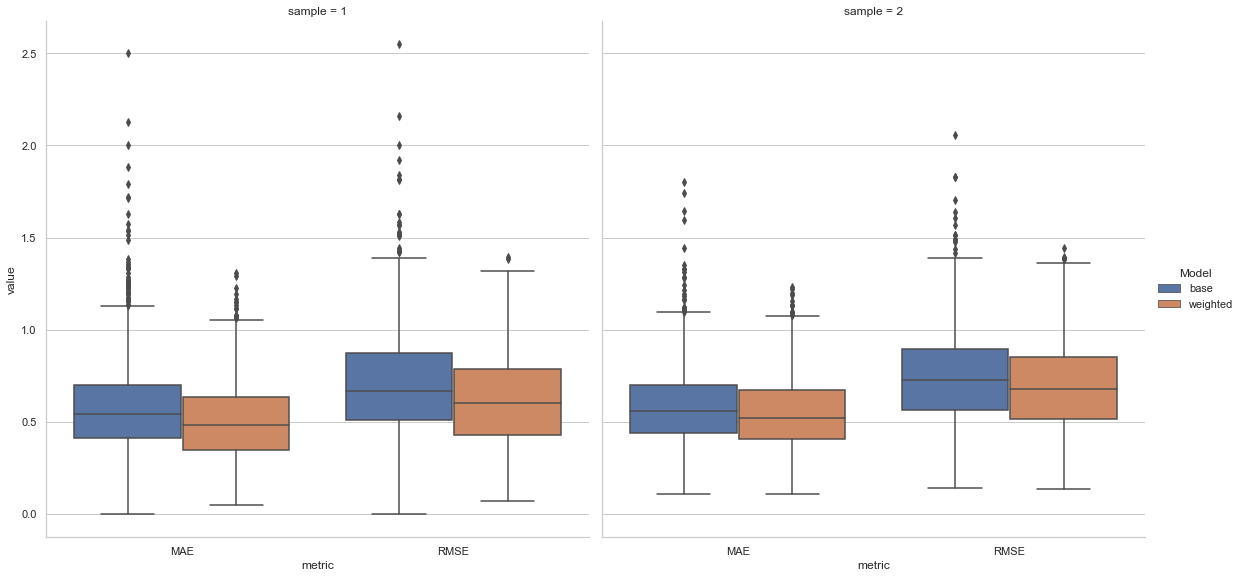

In [346]:
g = sns.catplot(x="metric", y="value", hue="Model",
                col="sample",
                data=df_errors_all, kind="box",
                height=8, aspect=1)

to be honest I have no idea why does pseudo random sampling shows better results, but anyway I will claim it to be withing margin of error, and not some kind of systematic bias

bootstrapping and cross-validation at some point was created for that exact reason

### Для каждого тестового пользователя сгенерируйте рекомендации топ 10, 15, 20, 50, 100 фильмов у которых нет оценок. Посчитайте NDCG считая хорошими фильмы с оценкой 4 и выше.

In [363]:
def rfunc_4(x):
    if x >= 4:
        return 1
    else:
        return 0

# def NDCGk(real_values, model_order, rfunc = rfunc_4, k = 5):
#     ideal_score = sorted([rfunc(x) for x in real_values], reverse = True)
#     model_score = [rfunc(real_values[x]) for x in model_order]
#
#     DCG = 0
#     iDCG = 0
#     for i in range(k):
#         DCG += 2**model_score[i]/log2(i+2)
#     for i in range(k):
#         iDCG += 2**ideal_score[i]/log2(i+2)
#     return (DCG/iDCG)

In [470]:
def dict_to_asarray(my_dict, rfunc = None):
    rating_fixed = {}
    if rfunc != None:
        for m in my_dict:
            rating_fixed[m] = rfunc(my_dict[m])
    else:
        rating_fixed = my_dict
    result = np.asarray([list(dict(sorted(rating_fixed.items())).values())])
    # result = np.asarray([list(dict(sorted(dict_items)).values())])
    # result = [rfunc(result[x]) for x in result]
    return result

dict_to_asarray(critics_test['20'])

array([[1, 1]])

In [483]:
def evaluate_model_2(train, test,
                   rec_func = getRecommendations_weighted,
                   k = 5):

    ndcg = {}
    for u in test:
        user_predicted = rec_func(prefs=train, test=test,
                                  person = u,
                                  mode = "exact")
        sad_but_true = {}
        for m in user_predicted:
            sad_but_true[m] = critics_test[u][m]
        if len(sad_but_true) > 0:
            ndcg[u] = ndcg_score(
                y_true = dict_to_asarray(sad_but_true, rfunc=rfunc_4),
                y_score = dict_to_asarray(user_predicted),
                k = k
            )
    return ndcg

In [487]:
%%time
ndcg_weight = evaluate_model_2(critics_train, critics_test,
                               rec_func = getRecommendations,
                               k = 100)
ndcg_weight['10']

Wall time: 38.2 s


0.9828172442802199

In [488]:
print(np.mean(list(ndcg_weight.values()))) 

0.9390951365403322
